# Assignment — Diffusions and Epidemics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from zlib import adler32

### Task 1. Biased random walks, flow graphs (0.8 point)

In this task, we consider a concept of flow graphs, namely weighted networks where dynamics flows are embedded into the link weight. Flow graphs provide an integrated representation of the structure and dynamics of the system, which can then be analyzed with standard tools of network science. Recall that an unbiased random walk uses a transition matrix $P$ to calculate distribution vector $p(t)$

$$p(t+1) = P^Tp(t)$$

$$P = D^{-1}A$$

where $D$ is a degree matrix. Thereby, the probability to jump from $i$ to $j$ is 

$$P_{ij} = \frac{A_{ij}}{d_i}$$

That is, a walker select the next node uniformly from nearest neighbors. 

A biased random walk is defined as follows. Let each node $i$ be given a definite positive attribute $\alpha_i$. Then a walker located at node $i$ decides to jump onto one of its neighbors, say $j$, with a probability proportional to $\alpha_jA_{ij}$. Hence, the probability to jump from $i$ to $j$ is given by

$$P_{ij} = \frac{\alpha_j A_{ij}}{\sum_k \alpha_k A_{ik}}$$

The usefull property of a biased random walk is that it coincides with an unbiased random walks on a _flow graph_

$$A'_{ij} = \alpha_i A_{ij} \alpha_j$$

Let us build this graph and look at its structure.

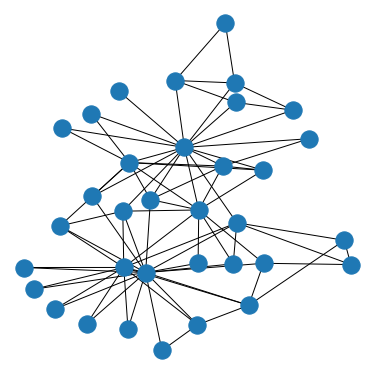

In [2]:
plt.figure(figsize=(5, 5))
G = nx.karate_club_graph()
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos)

Build a few flow graphs using some centralities: degree, betweenness, eigenvalue.

Write a function `degree_flow_graph` that takes a graph and returns a flow graph where $\alpha_i$ is a degree centrality value of a node $i$. All weights are bounded by $\alpha_i / \max(\alpha)$, that is the largest weight is 1.

Functions `betweenness_flow_graph` and `eigenvector_flow_graph` have the same form, they are based on betweenness and eigenvalue centrality respectively.

In [3]:
def build_flow_graph(G, a):
    A = nx.to_numpy_array(G)
    n = nx.number_of_nodes(G)
    for i in range(n):
        for j in range(n):
            A[i, j] *= a[i] * a[j]
    A /= A.max()
    return nx.from_numpy_matrix(A)

In [4]:
def degree_flow_graph(G):
    a = nx.degree_centrality(G)
    return build_flow_graph(G, a)

In [5]:
degreeG = degree_flow_graph(G)
assert len(G) == len(degreeG)
d_weight = np.array([d['weight'] for (u,v,d) in degreeG.edges(data=True)])
assert round(d_weight.sum(), 4) == 17.8431
assert round(d_weight[76], 4) == 0.5
assert round(d_weight[33], 4) == 0.0588
assert round(d_weight[31], 4) == 0.5882

In [6]:
def betweenness_flow_graph(G):
    a = nx.betweenness_centrality(G)
    return build_flow_graph(G, a)

In [7]:
betweennessG = betweenness_flow_graph(G)
assert len(G) == len(betweennessG)
b_weight = np.array([d['weight'] for (u,v,d) in betweennessG.edges(data=True)])
assert round(b_weight.sum(), 4) == 7.5463
assert round(b_weight[1], 4) == 1
assert round(b_weight[33], 4) == 0.1571
assert round(b_weight[31], 4) == 0.0041

In [8]:
def eigenvector_flow_graph(G):
    a = nx.eigenvector_centrality(G, tol=1e-10)
    return build_flow_graph(G, a)

In [9]:
eigenvectorG = eigenvector_flow_graph(G)
assert len(G) == len(eigenvectorG)
e_weight = np.array([d['weight'] for (u,v,d) in eigenvectorG.edges(data=True)])
assert round(e_weight.sum(), 4) == 29.1822
assert round(e_weight[75], 4) == 0.5117
assert round(e_weight[33], 4) == 0.1544
assert round(e_weight[31], 4) == 0.8496

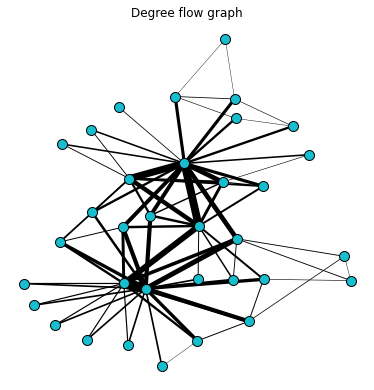

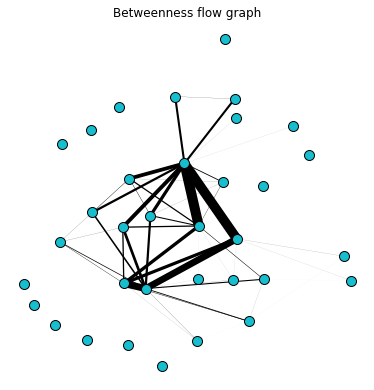

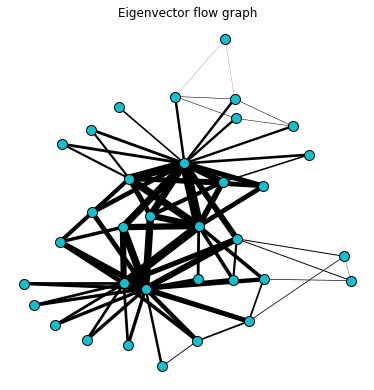

In [10]:
cases = [[degreeG, d_weight, 10, 'Degree'], 
         [betweennessG, b_weight, 10, 'Betweenness'], 
         [eigenvectorG, e_weight, 10, 'Eigenvector']]
for graph, weight, scale, title in cases:
    plt.figure(figsize=(5, 5))
    nx.draw(graph, 
            pos,
            node_size=100,
            edgecolors='black',
            node_color='tab:cyan',
            width=weight*scale)
    plt.title('{} flow graph'.format(title))
    plt.show()

Using unbiased random walk on an undirected graph, a probability of being on a node converges to a limit distribution vector

$$\lim_{t \to \infty} p(t) = \pi$$

$$\pi_i = \frac{d_i}{\sum_j d_j}$$

Similarly using biased random walks, it converges to a limit distribution vector

$$\pi_i' = \frac{\sum_j \alpha_i A_{ij} \alpha_j}{\sum_{i,j} \alpha_i A_{ij} \alpha_j}$$

Let us check this fact using an eigenvector flow graph.

Write a function `k_limit_distribution` that takes a graph, a number of iterations `k` and returns a tuple of 2 np.arrays:
* np.array of shape `(k+1, n)` where `n` is a number of nodes. i-th row contains distribution at time moment `t=i`. Here is a uniform distribution at `t=0`.
* np.array with limit distribution

In [11]:
def k_limit_distribution(G, k):
    A = nx.to_numpy_array(G)
    D_ = np.diag(1 / A.sum(axis=1))
    P = D_ @ A
    n = nx.number_of_nodes(G)
    pt = np.ones(n) / n
    res = [pt]
    for _ in range(k):
        pt = P.T @ pt
        res.append(pt)
    pt /= pt.sum()
    return np.array(res), pt

In [12]:
K = 10
k_d, limit_d = k_limit_distribution(eigenvectorG, K)
assert k_d.shape == (11, 34)
assert k_d[0].sum() == 1
assert k_d.sum() == 11
assert round(k_d[8, 8], 4) == 0.0528
assert round(k_d[0, 13], 4) == 0.0294

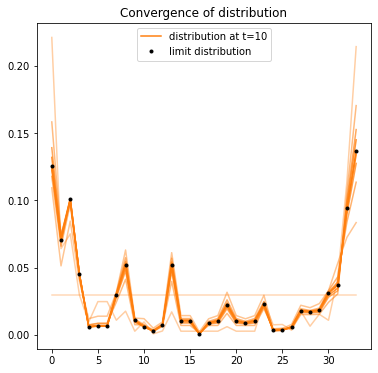

In [13]:
plt.figure(figsize=(6,6))
for k, alpha in enumerate(np.linspace(0.3, 0.9, 9)):
    plt.plot(k_d[k], color='tab:orange', alpha=alpha)
plt.plot(k_d[-1], color='tab:orange', label='distribution at t={}'.format(K))
plt.plot(limit_d, '.', color='black', label='limit distribution');
plt.legend()
plt.title('Convergence of distribution')
plt.show()

### Task 2. Diffusions on networks (2 points)

A diffusion process is a propagation model, where node values $\phi$ (say, 'heat') spread out of high concentration zone. Consider the diffusion on grid of the size 20x20. Let there be a 3x3 sub-grid with a heat value 3 and a 7x5 sub-grid with a heat value 1. All other nodes has a value 0. The initial heat values is $\phi_0$.

In [14]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

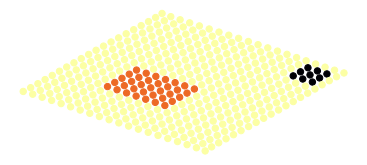

In [15]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0
)

Create a diffusion simulation based on this diffusion equation

$$\frac{d\phi}{dt} = -CL\phi$$

where $L$ is a graph Laplacian.

Write a function `next_phi` that takes an adjacency matrix `A`, np.array with previous heat values `phi`, constant `C` and time increment `dt`. The function returns a np.array with the next heat values.

In [16]:
def next_phi(A, phi, C, dt):
    D = np.diag(A.sum(axis=1))
    L = D - A
    dphi = -C * L @ phi * dt
    return phi + dphi

In [17]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

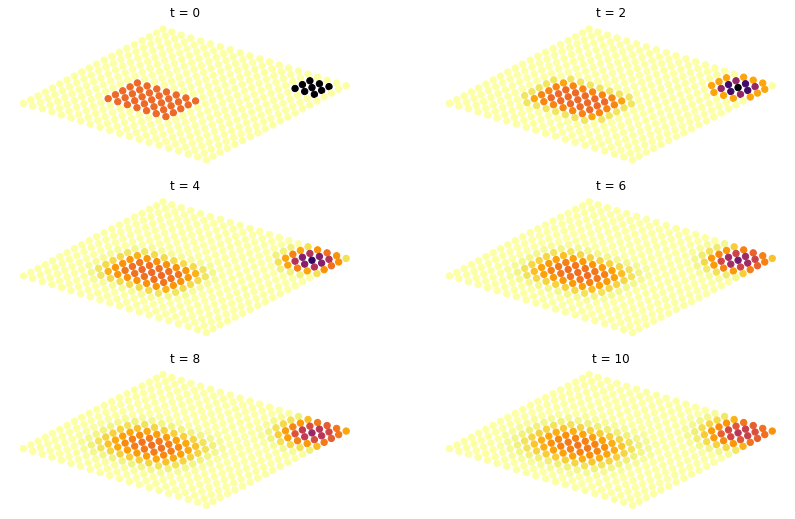

In [18]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

We can run simulation step-by-step as long as we need, but fortunately, there is an analytical solution

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

where $a_k(t) = \phi(t)^T v_k$ and $v_k$ is k-th smallest eigenvector of a Laplacian.

Write a function `phi_t` that takes an adjacency matrix `A`, np.array with initial heat values `phi0`, constant `C` and time moment `t`. The function returns a np.array with the heat values at time moment `t`. Use `np.linalg.eigh` or `scipy.linalg.eigh` for a symmetric matrix.

In [19]:
def phi_t(A, phi0, C, t):
    D = np.diag(A.sum(axis=1))
    L = D - A
    eig_vals, eig_vecs = np.linalg.eigh(L)
    
    phit = phi0.copy()
    for k in range(len(eig_vals)):
        ak0 = phi0.T * eig_vecs[k]
        expk = np.exp(-C * eig_vals[k] * t)
        phit += ak0 * expk * eig_vecs[k]
    return phit

In [20]:
def phi_t(A, phi0, C, t):
    dt = 1
    iterations = int(t / dt)
    phi = phi0.copy()
    for _ in range(iterations):
        phi = next_phi(A, phi, C, dt)
    return phi

In [21]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

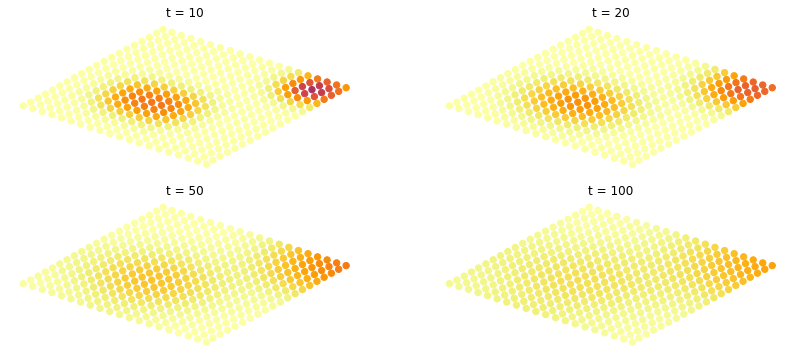

In [22]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

### Task 3. SI model (0.8 point)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [23]:
def si_epidemic(total, I0, beta, dt, k):
    S0 = total - I0
    res = [[S0, I0]]
    S, I = S0, I0
    for _ in range(k):
        dI = beta * S * I * dt / total
        I += dI
        S -= dI
        res.append([S, I])
    return np.array(res)

In [24]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

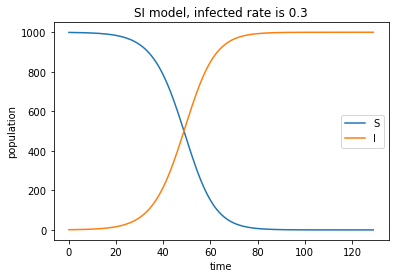

In [25]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

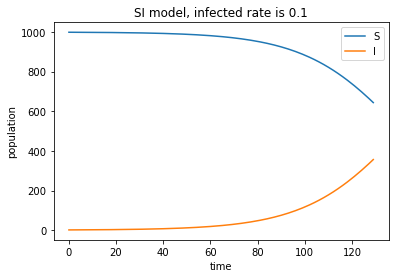

In [26]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 4. SIS model (1 point)

Next, consider SIS model. S — susceptible, I — infectious. At the next time moment, some susceptible people become infected with infection rate $\beta$ and some infected people become susceptible with recovery rate $\gamma$. The model is defined as follows:

Dynamic form

$$S \underset{\beta S I}{\to} I \underset{\gamma I}{\to} S$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I - \gamma I$$

$$S + I = N$$

where $N$ is the total population. 

Write a function `sis_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, recovery rate `gamma`, time increment `dt`, number of iterations `k` and returns a solution of the form of a np.array

`[[S0, I0], [S1, I1], ...]`

so that number of rows is `k+1`.

In [27]:
def sis_epidemic(total, I0, beta, gamma, dt, k):
    S0 = total - I0
    res = [[S0, I0]]
    S, I = S0, I0
    for _ in range(k):
        dI = (beta * S * I / total - gamma * I) * dt
        I += dI
        S -= dI
        res.append([S, I])
    return np.array(res)

In [28]:
total = 1000
beta, gamma = 0.3, 0.1
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=600-1)
assert solution.shape == (600, 2)
assert np.all(solution[0] == [900, 100])
assert np.all(solution[10].round(2) == [861.63, 138.37])
assert solution[-1, 1].round(2) == round((1 - gamma / beta) * total, 2)
assert adler32(str(solution[100].round(2)[0]).encode()) == 72548667

Here is the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $i(+\infty) \to (1 - \gamma / \beta)$
* If $R_0 < 1$: Disease-free State, $i(+\infty) \to 0$

where $i(t)$ is the share of infected people at the time moment $t$.

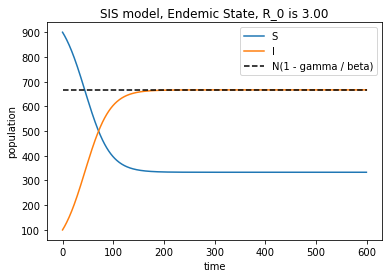

In [29]:
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.plot([0, 600], [limit, limit], '--', c='black')
plt.legend(['S', 'I', 'N(1 - gamma / beta)'])
plt.title('SIS model, Endemic State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

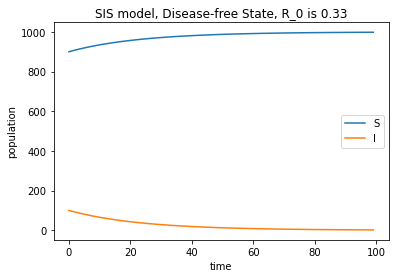

In [30]:
beta, gamma = 0.1, 0.3
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=100-1)
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.legend(['S', 'I'])
plt.title('SIS model, Disease-free State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 5. SIR model (0.7 point)

The next model is SIR. S — susceptible, I — infectious, R — recovered people. Initialy we only have a few infected persons and others are susceptible. Then some susceptible people become infected with infection rate $\beta$ and some infected people recover with recovery rate $\gamma$. There is no chance to infect after recovering. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R$$

Equation form (in proportions of the population)

$$\begin{cases}
ds/dt = -\beta si\\
di/dt = \beta si - \gamma i\\
dr/dt = \gamma i\\
s+i+r = 1
\end{cases}$$

Write a function `sir_epidemic` that takes an initial proportion `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [31]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    res = [[s0, i0, r0]]
    s, i, r = s0, i0, r0
    for _ in range(k):
        ds = -beta * s * i * dt
        di = (beta * s * i - gamma * i) * dt
        dr = gamma * i * dt
        s += ds
        i += di
        r += dr
        res.append([s, i, r])
    return np.array(res)

In [32]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Here is also the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $r(+\infty) \to 1$
* If $R_0 < 1$: Disease-free State, $r(+\infty) \to \text{const}$

where $r(t)$ is the share of recovered people at the time moment $t$.

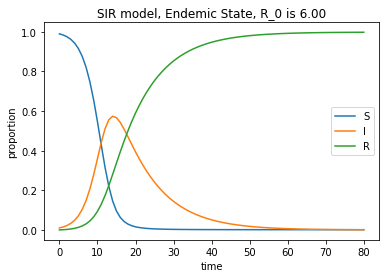

In [33]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

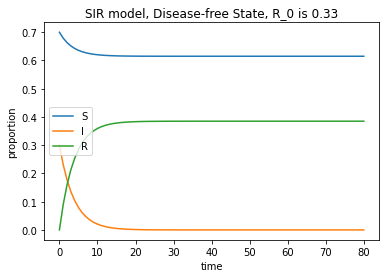

In [34]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

### Task 6. SIRS model (2 points)

The next model is SIRS, that is the same as SIR with an exception that recovered people lose their immunity with rate $\delta$. The dynamic form is

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R \underset{\delta R}{\to} S$$

Try to find an equation form using a dynamic form and implement this model.

Write a function `sirs_epidemic` that takes an initial proportion of `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, loss of immunity rate `delta`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [35]:
def sirs_epidemic(s0, i0, r0, beta, gamma, delta, k, dt):
    res = [[s0, i0, r0]]
    s, i, r = s0, i0, r0
    for _ in range(k):
        ds = (-beta * s * i + delta * r) * dt
        di = (beta * s * i - gamma * i) * dt
        dr = (gamma * i - delta * r) * dt
        s += ds
        i += di
        r += dr
        res.append([s, i, r])
    return np.array(res)

In [36]:
s0, i0, r0 = 0.9, 0.1, 0
beta, gamma, delta = 0.7, 0.3, 0.03
dt = 1
epidemic = sirs_epidemic(s0, i0, r0, beta, gamma, delta, 200, dt)
assert epidemic.shape == (201, 3)
assert np.all(epidemic[0] == [0.9, 0.1, 0])
assert np.all(epidemic[5].round(2) == [0.48, 0.27, 0.25])
assert np.all(epidemic[80].round(2) == [0.39, 0.05, 0.56])
assert np.all(epidemic[200].round(2) == [0.43, 0.05, 0.52])
assert adler32(str(epidemic[10].round(2).max()).encode()) == 32506060

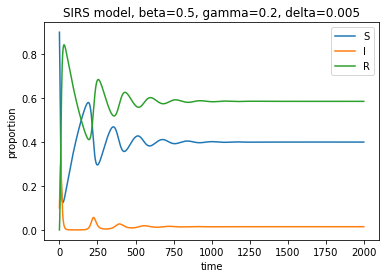

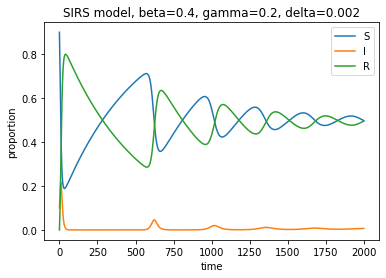

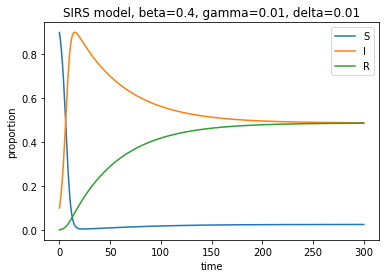

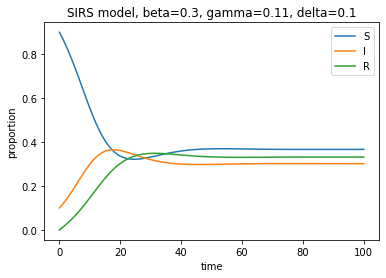

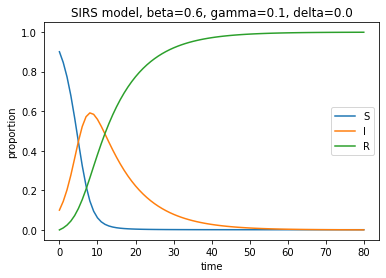

In [37]:
cases = [[0.5, 0.20, 0.005, 2000],
         [0.4, 0.20, 0.002, 2000],
         [0.4, 0.01, 0.010, 300 ],
         [0.3, 0.11, 0.100, 100 ],
         [0.6, 0.10, 0.000, 80  ]]
for beta, gamma, delta, k in cases:
    epidemic = sirs_epidemic(s0, i0, r0, beta, gamma, delta, k, dt)
    plt.plot(epidemic)
    plt.legend(['S', 'I', 'R'])
    plt.xlabel('time')
    plt.ylabel('proportion')
    plt.title('SIRS model, beta={}, gamma={}, delta={}'.format(beta, gamma, delta, k))
    plt.show()

### Task 7. SIS model on networks (0.7 point)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [38]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [39]:
def sis_networks(G, S, I, beta, gamma, k):
    A = nx.to_numpy_array(G)
    res = [[S, I]]
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta) - select_nodes(I, gamma)
        I = I + dI
        S = 1 - I
        res.append([S, I])
    return np.array(res)

In [40]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050
sigma = 6.3853
mean = 16.0198
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < mean + 2*sigma
sigma = 5.953
mean = 34.2178
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < mean + 2*sigma

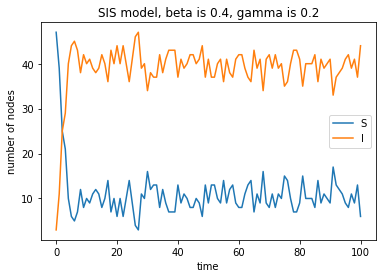

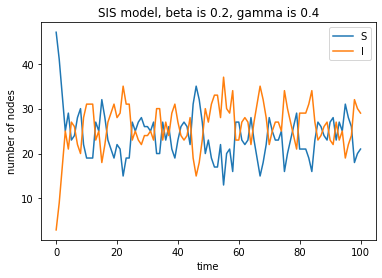

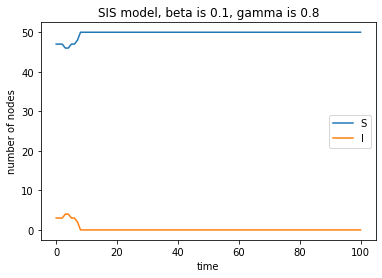

In [41]:
cases = [[0.4, 0.2], [0.2, 0.4], [0.1, 0.8]]
for beta, gamma in cases:
    epidemic = sis_networks(G, S, I, beta, gamma, 100)
    plt.plot(epidemic.sum(axis=2))
    plt.legend(['S', 'I'])
    plt.title('SIS model, beta is {:.1f}, gamma is {:.1f}'.format(beta, gamma))
    plt.xlabel('time')
    plt.ylabel('number of nodes')
    plt.show()

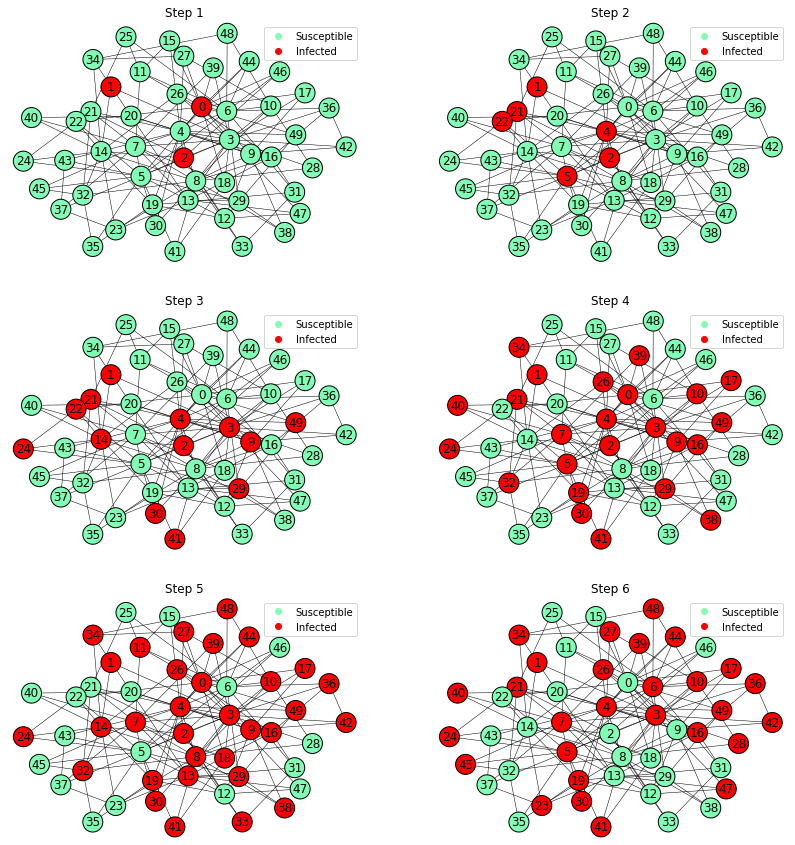

In [42]:
beta = 0.2
gamma = 0.2
epidemic = sis_networks(G, S, I, beta, gamma, 100)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 8. SIRS model on networks (2 points)

We already done compartmental SIRS model, let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [43]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    A = nx.to_numpy_array(G)
    res = [[S, I, R]]
    for _ in range(k):
        sn_delta = select_nodes(R, delta)
        sn_beta = select_nodes(I @ A * S, beta)
        sn_gamma = select_nodes(I, gamma)
        dS = sn_delta - sn_beta
        dI = sn_beta - sn_gamma
        dR = sn_gamma - sn_delta
        I = I + dI
        S = S + dS
        R = R + dR
        res.append([S, I, R])
    return np.array(res)

In [44]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

beta = 0.1
gamma = 0.3
delta = 0.1

epidemic = sirs_networks(G, S, I, R, beta, gamma, delta, 200)
assert epidemic.shape == (201, 3, 40)
assert (epidemic.sum(axis=1) == 1).sum() == 8040
assert (epidemic[200].sum(axis=1) == [40, 0, 0]).sum() == 3

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

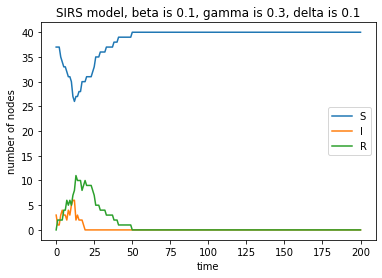

In [45]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R'])
plt.title('SIRS model, beta is {:.1f}, gamma is {:.1f}, delta is {:.1f}'.format(beta, gamma, delta))
plt.xlabel('time')
plt.ylabel('number of nodes')
plt.show()

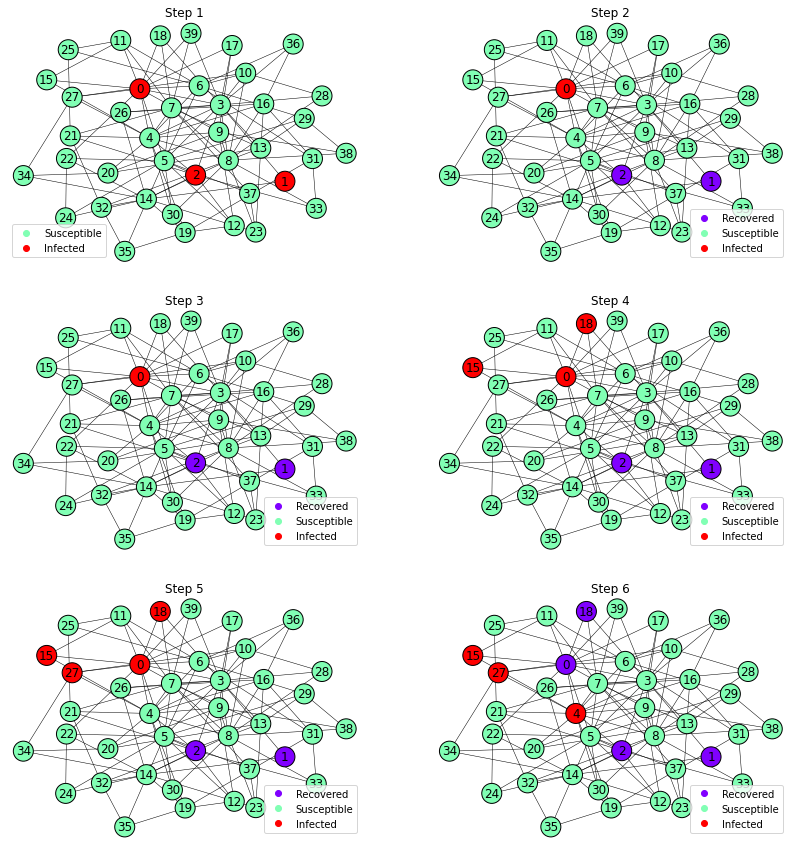

In [46]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1